# Mods

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import joblib

import statsmodels.api as sm

from patsy import dmatrix

from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier

from statsmodels.sandbox.stats.multicomp import multipletests

from sklearn.naive_bayes import MultinomialNB , GaussianNB

from collections import OrderedDict

from sklearn.model_selection import train_test_split ,  RandomizedSearchCV ,  KFold , cross_val_score

from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import confusion_matrix, classification_report , mean_squared_error , make_scorer, recall_score , r2_score


# Data Understanding

In [2]:
Df = pd.read_csv("/home/r00323024/Xwines/files/Xwines(1).csv")

In [5]:
Df.head(1)

,WineID,Vintage,Rating,Date,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Country,RegionName,WineryName
0,136103,1950,4.0,2019-10-14 11:20:52,Lambrusco Emilia,Red,Varietal/100%,['Lambrusco'],"['Beef', 'Pasta', 'Lamb', 'Game Meat']",7.5,Full-bodied,High,Italy,Emilia,Riunite


In [ ]:
# Df.loc[Df['WineryName'] == "Luis Felipe Edwards"]

In [48]:
Df1 = Df[Df["Vintage"] != "N.V."]

Df1["Vintage"] = pd.to_numeric(Df1["Vintage"])

<Axes: >

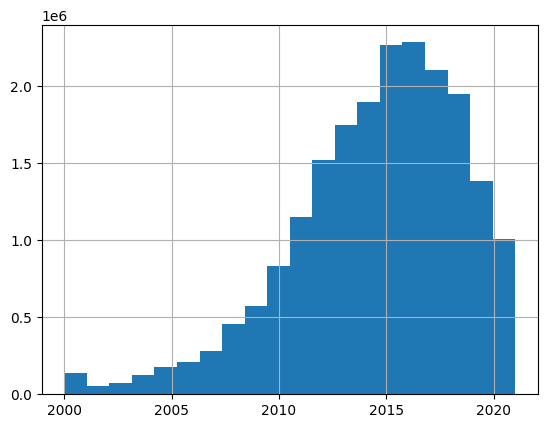

In [52]:
Df1 = Df1[Df1['Vintage'] >= 2000]
Df1['Vintage'].hist(bins=20)

# NB

In [3]:
df = Df.copy()

In [4]:
df = df[df["Vintage"] != "N.V."]

df["Vintage"] = pd.to_numeric(df["Vintage"])

df["Vintage"] = df["Vintage"].astype(str)

df['Date'] = pd.to_datetime(df['Date'])

df['min_date'] = df.groupby(['Vintage', 'UserID', 'WineName'])['Date'].transform('max')

df = df[df['Date'] == df['min_date']]

df = df.drop_duplicates(subset=['Vintage', 'UserID', 'WineName'])

Type = ['Red']
df = df[df['Type'].isin(Type)]

labels = df['WineryName'] + ' ' + df['Vintage']
df["Label"] = labels

Label_counts = df.groupby("Label").size()

df['amount'] = df['Label'].map(Label_counts)

In [5]:
df1 = df.copy()

In [10]:
pd.set_option('display.max_columns', None)
df1.head(1)

,RatingID,UserID,WineID,Vintage,Rating,Date,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,Country,RegionID,RegionName,WineryID,WineryName,Website,Vintages,min_date,Label,amount
40184,40185,1022435,111631,1979,4.5,2018-03-25 02:30:16,Vin Rouge,Red,Assemblage/Blend,"['Syrah/Shiraz', 'Grenache']","['Beef', 'Pasta', 'Veal']",12.0,Full-bodied,High,FR,France,1328,Languedoc-Roussillon,26791,Baron d'Arignac,http://www.baron-darignac.com,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201...",2018-03-25 02:30:16,Baron d'Arignac 1979,577


In [6]:
# encode 類別變數
label_encoder = LabelEncoder()

df1['Elaborate'] = label_encoder.fit_transform(df1['Elaborate'])
df1['Grapes'] = label_encoder.fit_transform(df1['Grapes'])
df1['Body'] = label_encoder.fit_transform(df1['Body'])
df1['Acidity'] = label_encoder.fit_transform(df1['Acidity'])
df1['Label'] = label_encoder.fit_transform(df1['Label'])

In [8]:
max_rating = df1['Rating'].max()

df1['Rating'] = (df1['Rating'] / max_rating) * 10
df1 = df1.drop(df1[(df1['Rating'] >= 4) & (df1['Rating'] <= 7)].index)

def map_rating(x):
    if x < 4:
        return 0
    
    else:
        return 1 

# 應用函數到rating列
df1['Rating'] = df1['Rating'].apply(map_rating)


In [9]:
y = df1['Rating'] 
X = df1[['Elaborate','Grapes','ABV','Body','Acidity','Label']]
X = df1[['Label']]

In [10]:
NB = MultinomialNB(alpha=1.0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,stratify=y,random_state=1)

NB.fit(X_train, y_train)

MultinomialNB()

In [20]:
joblib.dump(NB, '/home/r00323024/Xwines/files/NB.joblib')

['/home/r00323024/Xwines/files/NB.joblib']

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     38980
           1       0.98      1.00      0.99   2476228

    accuracy                           0.98   2515208
   macro avg       0.49      0.50      0.50   2515208
weighted avg       0.97      0.98      0.98   2515208



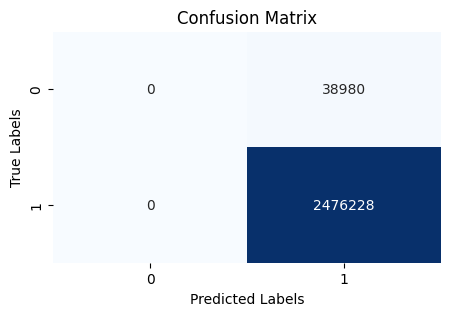

In [11]:

y_pred = NB.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')


report = classification_report(y_test, y_pred)
print(report)

# Tree

In [49]:
y = df1[['Rating']]
X = df1[['Elaborate','Grapes','ABV','Body','Acidity']]

In [12]:
rus = RandomOverSampler(random_state = 1)
X, y = rus.fit_resample(X, y)

In [13]:
clf = DecisionTreeClassifier(random_state=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1)

clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
from sklearn.datasets import load_digits
from scipy.stats import randint

# 定義參數分佈
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 30),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
}

# 使用 precision 作為評估指標
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=100, cv=5, scoring='precision')
random_search.fit(X, y)

# 打印最佳參數
print("Best parameters:", random_search.best_params_)

# 訓練最佳模型
best_dt_model = random_search.best_estimator_

# 使用最佳模型進行預測
y_pred = best_dt_model.predict(X)

# 計算 precision
precision = precision_score(y, y_pred, average='weighted')
print("Precision:", precision)


              precision    recall  f1-score   support

           0       0.75      0.79      0.77   2475452
           1       0.78      0.73      0.75   2477005

    accuracy                           0.76   4952457
   macro avg       0.76      0.76      0.76   4952457
weighted avg       0.76      0.76      0.76   4952457



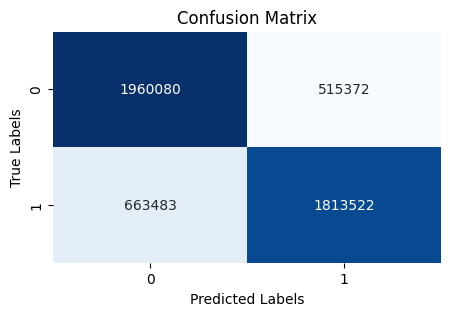

In [15]:

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')


report = classification_report(y_test, y_pred)
print(report)

In [21]:
joblib.dump(clf, '/home/r00323024/Xwines/files/rf.joblib')

['/home/r00323024/Xwines/files/rf.joblib']

In [22]:
rf = joblib.load('/home/r00323024/Xwines/files/rf.joblib')

In [20]:
rf.score(X, y)

0.18597112137386884

# OLS

In [4]:
df = Df.copy()

df = df[df["Vintage"] != "N.V."]

df["Vintage"] = pd.to_numeric(df["Vintage"])

df["Vintage"] = df["Vintage"].astype(str)

df['Date'] = pd.to_datetime(df['Date'])

df['min_date'] = df.groupby(['Vintage', 'UserID', 'WineName'])['Date'].transform('max')

df = df[df['Date'] == df['min_date']]

df = df.drop_duplicates(subset=['Vintage', 'UserID', 'WineName'])

Type = ['Red']
df = df[df['Type'].isin(Type)]

labels = df['WineryName'] + ' ' + df['Vintage']
df["Label"] = labels

Label_counts = df.groupby("Label").size()

df['amount'] = df['Label'].map(Label_counts)

In [61]:
x_values = [250, 500, 750, 1000]

# 计算满足条件的行数
counts = [len(df[df['amount'] > x]) for x in x_values]

# 将结果存储在字典中，以便后续处理
result = dict(zip(x_values, counts))

result

{250: 8523222, 500: 6324843, 750: 5047239, 1000: 4219898}


In [11]:
df1 = df[df['amount'] > 500]

In [ ]:
columns_to_group = ['WineID',"Label"]
df1 =df1.groupby(columns_to_group)['Rating'].mean().reset_index()

In [68]:
df1.sample(5)

,WineID,Label,Rating
47787,168335,Alfredo Roca 2014,3.336207
61492,181668,Wente Vineyards 2014,4.045455
47156,168194,Trapiche 2015,3.579365
55756,174913,Penfolds 2018,3.500000
28061,156421,Matarromera 2016,3.833333


In [13]:
%load_ext sql
%sql sqlite://

conn = sqlite3.connect(':memory:')  # Use ':memory:' for in-memory database

df1.to_sql('table1', conn, index=False, if_exists='replace')

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


64189

In [14]:
Rating = pd.read_sql_query("SELECT Rating FROM table1;", conn)
Label = pd.read_sql_query("SELECT Label FROM table1;", conn)

In [15]:
X = pd.get_dummies(Label , sparse = True).astype(int)

In [16]:
new_cols = [col.removeprefix('Label_') for col in X.columns]
X.columns = new_cols

In [17]:
X

,1000 Stories 2014,1000 Stories 2015,1000 Stories 2016,1000 Stories 2017,1000 Stories 2018,14 Hands 2011,14 Hands 2012,14 Hands 2013,14 Hands 2014,14 Hands 2015,...,d'Arenberg 2020,Álvaro Palacios 2011,Álvaro Palacios 2012,Álvaro Palacios 2013,Álvaro Palacios 2014,Álvaro Palacios 2015,Álvaro Palacios 2016,Álvaro Palacios 2017,Álvaro Palacios 2018,Álvaro Palacios 2019
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64184,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64185,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64186,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64187,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
X = sm.add_constant(X)  
y = Rating

In [ ]:
model = sm.OLS(y, X)
results = model.fit()

rsquared = results.rsquared
print("R-squared:", rsquared)

In [49]:
coefficients = results.params
std_errs = results.bse
t_values = results.tvalues
p_values = results.pvalues
conf_ints = results.conf_int()

# Creating a DataFrame to store the results
result_df = pd.DataFrame({
    'Coefficient': coefficients,
    'Std Error': std_errs,
    't-value': t_values,
    'P-value': p_values,
    'Confidence Interval (0.025)': conf_ints[0],
    'Confidence Interval (0.975)': conf_ints[1]
})

# Rounding to 8 decimal places
result_df = result_df.round(10)
# Displaying the DataFrame
result_df

,Coefficient,Std Error,t-value,P-value,Confidence Interval (0.025),Confidence Interval (0.975)
const,3.881915,0.002270,1709.724304,0.000000,3.877465,3.886365
1000 Stories 2014,0.409561,0.234168,1.749009,0.080295,-0.049408,0.868531
1000 Stories 2015,0.207645,0.202798,1.023897,0.305888,-0.189841,0.605130
1000 Stories 2016,0.137029,0.202798,0.675692,0.499239,-0.260456,0.534515
1000 Stories 2017,0.113342,0.202798,0.558892,0.576238,-0.284143,0.510828
...,...,...,...,...,...,...
Álvaro Palacios 2015,0.456342,0.135209,3.375074,0.000738,0.191331,0.721353
Álvaro Palacios 2016,0.496181,0.135209,3.669719,0.000243,0.231170,0.761192
Álvaro Palacios 2017,0.592790,0.143409,4.133561,0.000036,0.311708,0.873873
Álvaro Palacios 2018,0.638956,0.143409,4.455478,0.000008,0.357874,0.920038


In [43]:
# 設定一個數字
num_tests = 30

def bonferroni (pval, num_tests):

    alpha_0001 = 0.0001 / num_tests
    alpha_001 = 0.001 / num_tests
    alpha_01 = 0.01 / num_tests
    alpha_05 = 0.05 / num_tests

    if pval < alpha_0001:
        return '****'
    elif pval < alpha_001:
        return '***'
    elif pval < alpha_01:
        return '**'
    elif pval < alpha_05:
        return '*'
    else:
        return ''

result_df['P-value'] = result_df['P-value'].astype(float).apply(lambda x: f"{x:.8f}" + bonferroni(x, num_tests))


In [44]:
file_path = "/home/r00323024/Xwines/files/OLS2.txt"
with open(file_path, "w") as f:
     f.write(result_df.to_string())

In [46]:
Toplist = result_df.copy()

cols = ['Std Error','Confidence Interval (0.025)','Confidence Interval (0.975)']
Toplist.drop(cols, axis=1, inplace=True)

In [48]:
Toplist = Toplist[(Toplist['Coefficient'] > 0.8) & (Toplist['P-value'].str.contains(r'\*'))]

file_path = "/home/r00323024/Xwines/files/Toplist.txt"
with open(file_path, "w") as f:
     f.write(Toplist.to_string())

In [55]:

# Benjamini-Hochberg过程
reject, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# Check if there are any NaN values in the corrected p-values
if np.isnan(corrected_p_values).any():
    print("Warning: NaN values found in corrected p-values.")

# Convert corrected_p_values to a Pandas Series
corrected_p_values_series = pd.Series(corrected_p_values)

# Apply formatting and add asterisks based on reject
result_df['P-value'] = corrected_p_values_series.apply(lambda x: f"{x:.8f}") + np.where(reject, '*', '')


In [56]:
result_df

,Coefficient,Std Error,t-value,P-value,Confidence Interval (0.025),Confidence Interval (0.975)
const,3.881915,0.002270,1709.724304,NaN,3.877465,3.886365
1000 Stories 2014,0.409561,0.234168,1.749009,NaN,-0.049408,0.868531
1000 Stories 2015,0.207645,0.202798,1.023897,NaN,-0.189841,0.605130
1000 Stories 2016,0.137029,0.202798,0.675692,NaN,-0.260456,0.534515
1000 Stories 2017,0.113342,0.202798,0.558892,NaN,-0.284143,0.510828
...,...,...,...,...,...,...
Álvaro Palacios 2015,0.456342,0.135209,3.375074,NaN,0.191331,0.721353
Álvaro Palacios 2016,0.496181,0.135209,3.669719,NaN,0.231170,0.761192
Álvaro Palacios 2017,0.592790,0.143409,4.133561,NaN,0.311708,0.873873
Álvaro Palacios 2018,0.638956,0.143409,4.455478,NaN,0.357874,0.920038
